In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import math
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(111)

In [3]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cuda')

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor() , transforms.Normalize((0.5,) , (0.5 ,))]
)

In [5]:
train_set = torchvision.datasets.MNIST( root = '.' , train = True , download = True , transform = transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 222506107.74it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 22799867.09it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 76136018.72it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4808311.15it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



size of each image torch.Size([1, 28, 28])
label 3


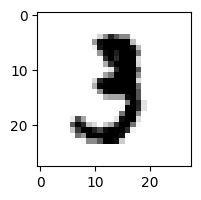

In [6]:
sample_numb = 10
print("size of each image" , train_set[sample_numb][0].shape)
print("label" , train_set[sample_numb][1])
plt.figure(figsize= (2,2))
plt.imshow(train_set[sample_numb][0].reshape(28,28) , cmap = 'gray_r' )


In [7]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(train_set , batch_size = batch_size , shuffle = True)

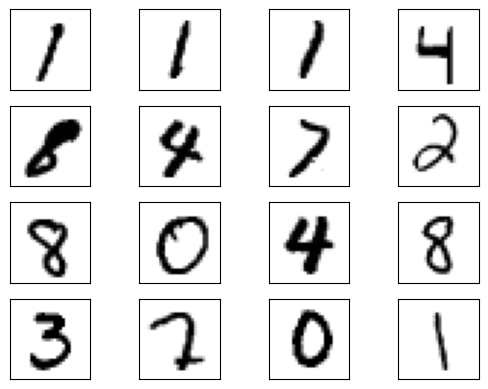

In [8]:
real_samples , mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4 , 4 , i+1)
    plt.imshow(real_samples[i].reshape(28,28) , cmap = 'gray_r')
    plt.xticks([])
    plt.yticks([])

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784 , 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024 , 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512 , 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256 , 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self , x):
        x = x.view(x.size(0) , 784)
        output = self.model(x)
        return output

discriminator = Discriminator().to(device = device)

In [10]:
# Since the generator is going to generate more complex data, it’s necessary to increase the dimensions of the input from the latent space.
# In this case, the generator is going to be fed a 100-dimensional input and will provide an output with 784 coefficients,
# which will be organized in a 28 × 28 tensor representing an image.

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device = device)


In [11]:
lr = 0.0001
loss = nn.BCELoss()
epochs = 50
optimizer_discriminator = torch.optim.Adam(discriminator.parameters() , lr = lr)
optimizer_generator = torch.optim.Adam(generator.parameters() , lr = lr )

In [12]:
for epoch in range(epochs):
    for n,(real_samples , mnist_labels) in enumerate(train_loader):
        real_samples = real_samples.to(device = device)
        mnist_labels = mnist_labels.to(device = device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device = device)
        latent_space_samples = torch.randn((batch_size , 100)).to(device = device)
        latent_space_labels = torch.zeros((batch_size, 1)).to(device = device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device = device)
        all_samples = torch.cat((real_samples , generated_samples))
        all_samples_labels = torch.cat((real_samples_labels , generated_samples_labels))

        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss(output_discriminator , all_samples_labels )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        latent_space_samples = torch.randn((batch_size , 100)).to(device = device)

        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        discriminator_output = discriminator(generated_samples)
        loss_generator = loss(discriminator_output , real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        generated_samples = generated_samples.cpu().detach()
        if n == batch_size - 1:

            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")

            print(f"Epoch: {epoch} Loss G.: {loss_generator}")


Epoch: 0 Loss D.: 0.5493449568748474
Epoch: 0 Loss G.: 0.6708452701568604
Epoch: 1 Loss D.: 0.04105875641107559
Epoch: 1 Loss G.: 4.6826934814453125
Epoch: 2 Loss D.: 0.032641224563121796
Epoch: 2 Loss G.: 4.034074783325195
Epoch: 3 Loss D.: 0.1613638699054718
Epoch: 3 Loss G.: 3.7365126609802246
Epoch: 4 Loss D.: 0.16633769869804382
Epoch: 4 Loss G.: 4.127302169799805
Epoch: 5 Loss D.: 0.058646395802497864
Epoch: 5 Loss G.: 4.569365501403809
Epoch: 6 Loss D.: 0.1736976057291031
Epoch: 6 Loss G.: 5.538266181945801
Epoch: 7 Loss D.: 0.029179487377405167
Epoch: 7 Loss G.: 5.233160972595215
Epoch: 8 Loss D.: 0.19735699892044067
Epoch: 8 Loss G.: 4.0013427734375
Epoch: 9 Loss D.: 0.13878251612186432
Epoch: 9 Loss G.: 2.5218095779418945
Epoch: 10 Loss D.: 0.08440017700195312
Epoch: 10 Loss G.: 2.608121871948242
Epoch: 11 Loss D.: 0.2351207733154297
Epoch: 11 Loss G.: 2.297801971435547
Epoch: 12 Loss D.: 0.4701094627380371
Epoch: 12 Loss G.: 2.139587879180908
Epoch: 13 Loss D.: 0.29101711511

In [17]:
checkpoint = {
    'epochs' : epochs ,
    'generator_state_dict' : optimizer_generator.state_dict(),
    'discriminator_state_dict' : optimizer_discriminator.state_dict(),
    'generator_loss' : loss_generator,
    'discriminator_loss' : loss_discriminator
}

torch.save(checkpoint , 'Handwritten_digit_generator_checkpoint.pth')

In [23]:
latent_space_samples = torch.randn(batch_size , 100).to(device = device)
generated_samples = generator(latent_space_samples)

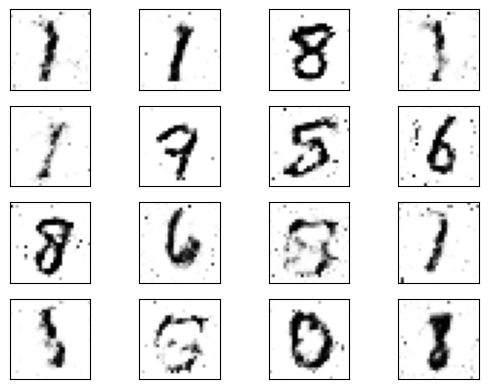

In [24]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4 , 4 , i+1)
    plt.imshow(generated_samples[i].reshape(28,28) , cmap = "gray_r")
    plt.xticks([])
    plt.yticks([])